In [1]:
!pip install kaggle
!pip install wordcloud

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"praneethratna","key":"1ffc3d4eb8d9e2d8b123587bece7ff97"}'}

In [3]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d quora/question-pairs-dataset
import shutil
shutil.unpack_archive('question-pairs-dataset.zip')

 43% 9.00M/20.8M [00:00<00:00, 20.2MB/s]
100% 20.8M/20.8M [00:00<00:00, 35.4MB/s]


In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, Attention, Dense, BatchNormalization, Dropout, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from keras.callbacks import ModelCheckpoint
from wordcloud import WordCloud

In [6]:
data = pd.read_csv('questions.csv')
data.describe()

,id,qid1,qid2,is_duplicate
count,404351.000000,404351.000000,404351.000000,404351.000000
mean,202175.000000,391840.987691,390195.973765,0.369248
std,116726.223686,228430.857607,228803.645742,0.482602
min,0.000000,1.000000,2.000000,0.000000
25%,101087.500000,193381.000000,191012.000000,0.000000
50%,202175.000000,390630.000000,388364.000000,0.000000
75%,303262.500000,589514.000000,588071.000000,1.000000
max,404350.000000,789800.000000,789801.000000,1.000000


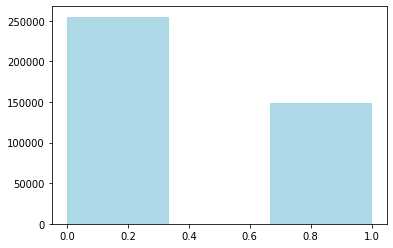

In [41]:
q1 = list(data['question1'].astype(str))
q2 = list(data['question2'].astype(str))
target = data['is_duplicate']
plt.hist(target, color = 'lightblue', bins = 3)
plt.show()

In [45]:
tokenizer = Tokenizer(lower=True)
tokenizer.fit_on_texts(q1+q2)
word_index = tokenizer.word_index

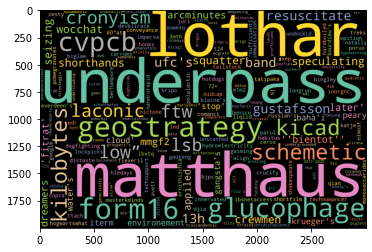

In [47]:
wordcloud = WordCloud(width = 3000, height = 2000,
                      random_state=1, background_color='black', colormap='Set2', collocations=False).generate_from_frequencies(word_index)
plt.imshow(wordcloud)                      

In [52]:
def padding(texts):
  sequences = tokenizer.texts_to_sequences(texts)
  padded = pad_sequences(sequences,maxlen=30,padding='pre')
  return padded
padded1 = padding(q1)
padded2 = padding(q2)

In [66]:
embedding_dim = 300
vocab = len(word_index)
x = Input(shape=(30,))
y = Input(shape=(30,))
emb1 = Embedding(vocab, embedding_dim, mask_zero = True)(x)
emb1 = LSTM(embedding_dim)(emb1)
emb2 = Embedding(vocab, embedding_dim, mask_zero = True)(y)
emb2 = LSTM(embedding_dim)(emb2)
z = Attention(dropout=0.2)([emb1, emb2])
z = BatchNormalization()(z)
z = Dense(200)(z)
z = Dropout(0.2)(z)
z = Dense(1,activation='sigmoid')(z)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 30)]         0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 30, 300)      28680900    input_13[0][0]                   
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, 30, 300)      28680900    input_14[0][0]                   
____________________________________________________________________________________________

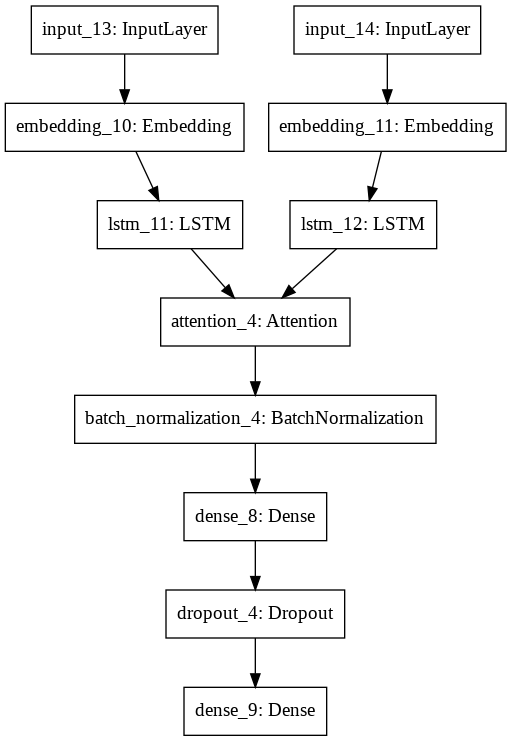

In [67]:
model = Model(inputs = [x,y], outputs = z)
model.summary()
plot_model(model)